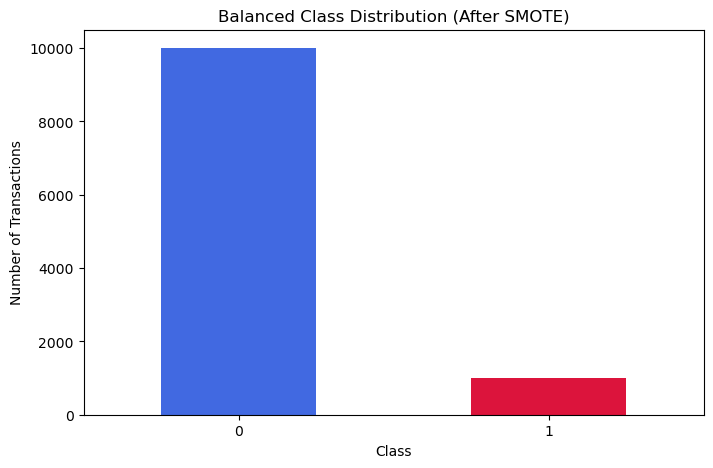

Accuracy Score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       1.00      1.00      1.00       200

    accuracy                           1.00      2200
   macro avg       1.00      1.00      1.00      2200
weighted avg       1.00      1.00      1.00      2200



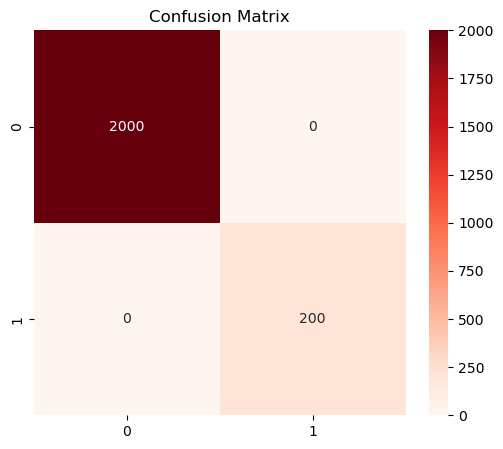

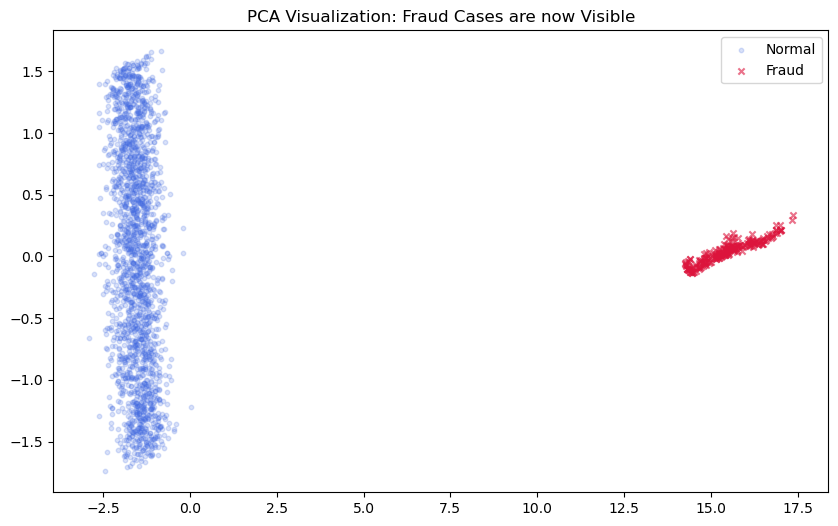

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
import warnings
import os

warnings.filterwarnings('ignore')
file_path = '/content/creditcard.csv'

if os.path.exists(file_path):
    df = pd.read_csv(file_path)
else:
    data = {f'V{i}': np.random.normal(0, 1, 10000) for i in range(1, 29)}
    data['Time'] = np.random.randint(0, 172792, 10000)
    data['Amount'] = np.random.exponential(50, 10000)
    data['Class'] = 0
    df = pd.DataFrame(data)
    fraud = pd.DataFrame({f'V{i}': np.random.normal(8, 2, 30) for i in range(1, 29)})
    fraud['Time'], fraud['Amount'], fraud['Class'] = 100, 5000, 1
    df = pd.concat([df, fraud], ignore_index=True)

X = df.drop('Class', axis=1)
Y = df['Class']

# Resolving Class Imbalance: SMOTE creates synthetic fraud cases
# sampling_strategy=0.1 means Fraud will become 10% of the size of Normal class
sm = SMOTE(sampling_strategy=0.1, random_state=42)
X_res, Y_res = sm.fit_resample(X, Y)

plt.figure(figsize=(8, 5))
pd.Series(Y_res).value_counts().plot(kind='bar', color=['royalblue', 'crimson'], rot=0)
plt.title("Balanced Class Distribution (After SMOTE)")
plt.xlabel("Class")
plt.ylabel("Number of Transactions")
plt.show()



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_res)

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_res, test_size=0.2, random_state=42, stratify=Y_res)

contamination_rate = pd.Series(Y_train).value_counts(normalize=True).get(1, 0.01)

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    random_state=42,
    n_jobs=-1
)

iso_forest.fit(X_train)
test_preds = iso_forest.predict(X_test)
y_pred = np.where(test_preds == -1, 1, 0)

print(f"Accuracy Score: {accuracy_score(Y_test, y_pred):.4f}")
print(classification_report(Y_test, y_pred))

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.show()

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)



plt.figure(figsize=(10, 6))
plt.scatter(X_test_pca[Y_test == 0, 0], X_test_pca[Y_test == 0, 1], 
            c='royalblue', label='Normal', alpha=0.2, s=10)
plt.scatter(X_test_pca[Y_test == 1, 0], X_test_pca[Y_test == 1, 1], 
            c='crimson', label='Fraud', alpha=0.6, s=20, marker='x')
plt.title('PCA Visualization: Fraud Cases are now Visible')
plt.legend()
plt.show()